In [1]:
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Conv2DTranspose, concatenate, Activation, MaxPooling2D, Conv2D, BatchNormalization
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import utils
# from google.colab import files
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import VGG16, EfficientNetB0, ResNet101, DenseNet121
import numpy as np
from PIL import Image
import tensorflow as tf
import cv2


# Это наша метрика на Tensorflow
def dice_coef(y_true, y_pred):
    return (2. * tf.math.reduce_sum(y_true * y_pred) + 1.) / (tf.math.reduce_sum(y_true) + tf.math.reduce_sum(y_pred) + 1.)


In [2]:
# Датасет https://www.kaggle.com/datasets/metavision/accurate-wasp-shapessegmentation
PAHT_label = 'wasp/mask/'
PAHT_image = 'wasp/images/'

In [3]:
import os, fnmatch
imag = os.listdir(PAHT_label)
imag_label = os.listdir(PAHT_image)

In [4]:
# Уменьшим кол-во картинок
n = 200
imag = imag[:n]
imag_label = imag_label[:n]

In [5]:
imag[:2], imag_label[:2]

(['mask00000001.png', 'mask00000002.png'],
 ['image00000001.jpg', 'image00000002.jpg'])

In [6]:
len(imag), len(imag_label)

(200, 200)

In [7]:
images = []
segments = []
image_size = (640, 360)
for l_name, i_name in zip(imag, imag_label):
    images.append(image.load_img(PAHT_image+i_name ,target_size = image_size))
    segments.append(image.load_img(PAHT_label+l_name, target_size = image_size))

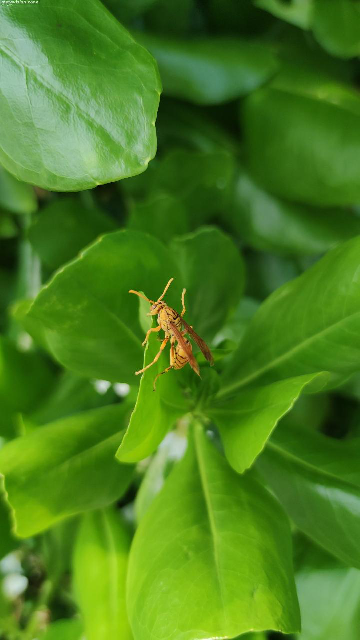

In [8]:
images[0]

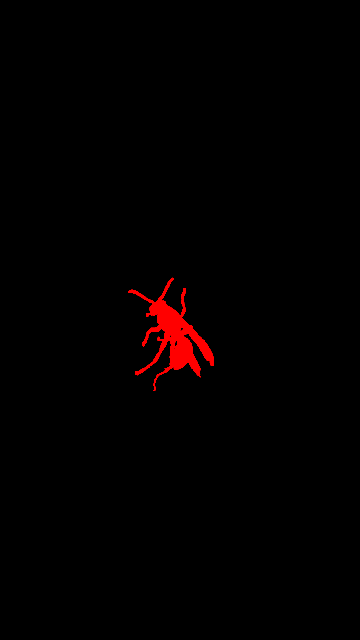

In [9]:
segments[0]

In [10]:
xTrain_Test = []

for img in images:
    x = image.img_to_array(img)
    xTrain_Test.append(x)

xTrain_Test = np.array(xTrain_Test)

In [11]:
print(xTrain_Test.shape)

(200, 640, 360, 3)


## У нас всего 2 класса
- Red - (255, 0, 0)
- Black - (0, 0, 0)

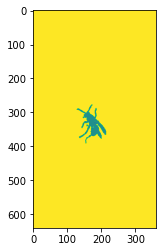

In [12]:
def Color2index(y):
  #y - входное изображение разметки (УхХхС - цветное )
  # карту цветов y_ind
  # карту ответов one-hot-encoding y_cat

  # список актуальных цветов разметки
    arr_col=[[255,0,0],[0,0,0]]
    y_ind = np.zeros((y.shape[0],y.shape[1]))
    y_cat = np.zeros((y.shape[0],y.shape[1], len(arr_col)))
    i = 1
    for i_color in arr_col:
        # найдем все точки цвета i_color
        ind_i = np.where((y[:,:,0] == i_color[0]) & (y[:,:,1] == i_color[1]) & (y[:,:,2] == i_color[2]))
    
        y_ind[ind_i[0],ind_i[1]] = i
        y_cat[ind_i[0],ind_i[1], i-1] = 1 
        i += 1
  
    return y_cat, y_ind, i-1

cat_yi,ind_yi,h = Color2index(image.img_to_array(segments[0]))
plt.imshow(ind_yi.astype(float)/h)
plt.show()  


In [13]:
np.max(cat_yi[:,:,1] )

1.0

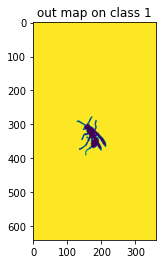

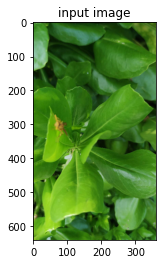

In [14]:
plt.imshow(cat_yi[:,:,1])
plt.title('out map on class 1')
plt.show()
plt.imshow(xTrain_Test[1,:,:,:]/255)
plt.title('input image')
plt.show()

In [15]:
yTrain_Test = []

for seg in segments:
    y_cat,_,_ = Color2index(image.img_to_array(seg))
    yTrain_Test.append(y_cat)

yTrain_Test = np.array(yTrain_Test)

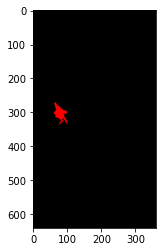

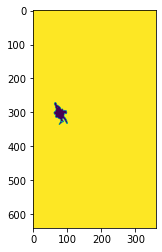

In [16]:
n = 1
plt.imshow(segments[n].convert('RGBA'))
plt.show()
img = yTrain_Test[n][:,:,n]
plt.imshow(img.astype(float))
plt.show()

#### Делим на трейн и тест

In [17]:
N = round(len(imag) * 0.7)
yTrain = yTrain_Test[:N,:,:,:]
xTrain = xTrain_Test[:N,:,:,:]

yTest = yTrain_Test[N:,:,:,:]
xTest = xTrain_Test[N:,:,:,:]

In [18]:
print(xTrain.shape)
print(yTrain.shape)

(140, 640, 360, 3)
(140, 640, 360, 2)


In [19]:
from tensorflow.keras.utils import plot_model

In [20]:
def Unet(num_classes = 2, input_shape= (640, 360, 3)):
  #num_classes = 2, - число классов ответа
  #input_shape= (640, 350, 3) - размер входной картинки

  #model - выходная модель

    img_input = Input(input_shape) # вход модели

    # Block 1
    x = Conv2D(64, (3, 3), padding='same', name='block1_conv1')(img_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(64, (3, 3), padding='same', name='block1_conv2')(x)
    x = BatchNormalization()(x)
    # запомним тензор для переноса
    block_1_out = Activation('relu')(x)

    x = MaxPooling2D()(block_1_out) # 100x300

    # Block 2
    x = Conv2D(128, (3, 3), padding='same', name='block2_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(128, (3, 3), padding='same', name='block2_conv2')(x)
    x = BatchNormalization()(x)
    # запомним тензор для переноса
    block_2_out = Activation('relu')(x)

    x = MaxPooling2D()(block_2_out) # 50x150

    # Block 3
    x = Conv2D(256, (3, 3), padding='same', name='block3_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv3')(x)
    x = BatchNormalization()(x)
    # запомним тензор для переноса
    block_3_out = Activation('relu')(x)

    x = MaxPooling2D()(block_3_out) #25x75

    # Block 4
    x = Conv2D(512, (3, 3), padding='same', name='block4_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv3')(x)
    x = BatchNormalization()(x)
    # запомним тензор для переноса
    block_4_out = Activation('relu')(x)

    # UP 2
    x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(x) #50x150
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # добавили перенос из понижаюшего плеча
    x = concatenate([x, block_3_out])
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 3
    x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x) # 100x300
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # добавили перенос из понижаюшего плеча
    x = concatenate([x, block_2_out])
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 4
    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(x) # 200x600
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # добавили перенос из понижаюшего плеча
    x = concatenate([x, block_1_out])
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # слой классификатор
    x = Conv2D(num_classes, (3, 3), activation='softmax', padding='same')(x)

    model = Model(img_input, x)
    model.compile(optimizer=Adam(),
                  loss='categorical_crossentropy',
                  metrics=[dice_coef])
    model.summary()
    return model

In [21]:
modelC = Unet(num_classes = 2, input_shape= (640, 360, 3))

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 640, 360, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 640, 360, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 640, 360, 64  256        ['block1_conv1[0][0]']           
 alization)                     )                                                             

In [22]:
%%time
history = modelC.fit(xTrain, yTrain, epochs=1, batch_size=1, validation_data=(xTrain, yTrain))

140/140 [==============================] - 44s 265ms/step - loss: 0.0249 - dice_coef: 0.9829 - val_loss: 0.0081 - val_dice_coef: 0.9935
Wall time: 44.9 s


In [23]:
pred = modelC.predict(xTest)
print(pred.shape)

2/2 [==============================] - 37s 17s/step
(60, 640, 360, 2)


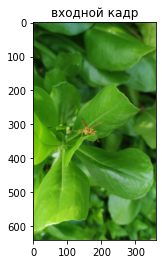

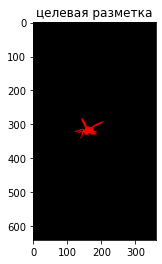

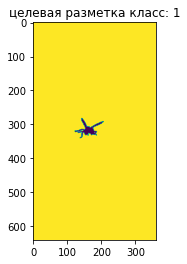

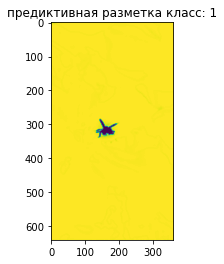

In [24]:
n = 10
class_ = 1
plt.imshow(images[N+n].convert('RGBA'))
plt.title('входной кадр')
plt.show()
plt.imshow(segments[N+n].convert('RGBA'))
plt.title('целевая разметка')
plt.show()
img = yTest[n][:,:,class_]
plt.imshow(img.astype(float))
plt.title('целевая разметка класс: '+str(class_))
plt.show()
img = pred[n][:,:,class_]
plt.imshow(img.astype(float))
plt.title('предиктивная разметка класс: '+str(class_))
plt.show()